In [1]:
from __future__ import division
import pathlib, os, sys, traceback
import numpy as np
import cv2, pygame, scipy, h5py
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import argparse
import numpy as np
#import multiprocessing as mp
from collections import Counter

from synthgen import *
from common import *


%load_ext autoreload
%autoreload 2

pygame 2.0.0 (SDL 2.0.12, python 3.9.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Maskformer panoptic

In [2]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import torch

import cv2
import numpy as np
import tqdm, time

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.utils.logger import setup_logger

from mask_former import add_mask_former_config
from predictor import VisualizationDemo

import argparse


#filename = 'seg_inputs/sample0.jpg' # WORKS
#filename = 'seg_inputs/sample6.jpg'  # WORKS
#filename = 'seg_inputs/sample2.jpg' # WORKS
#filename = 'seg_inputs/sample8.jpg' # WORKS
#filename = 'seg_inputs/sample7.jpg'# WORKS
#filename = 'seg_inputs/sample3.jpg' # DOESNOT WORK
#filename = 'seg_inputs/data3.jpg' # WORKS
#filename = 'seg_inputs/data8.png' # WORKS
#filename = 'seg_inputs/data11.png' # DOESNOT WORK WELL
filename = 'seg_inputs/data5.jpg'

def get_parser():
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/ade20k-150/maskformer_R50_bs16_160k.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input",
        nargs="+",
        help="A list of space separated input images; "
        "or a single glob pattern such as 'directory/*.jpg'",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )

    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser

args = get_parser().parse_args(args=[
    '--config-file', 'configs/ade20k-150-panoptic/maskformer_panoptic_R50_bs16_720k.yaml',
    '--opts', 'MODEL.WEIGHTS', 'model_final_7aa977.pkl'
])

def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_mask_former_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg


cfg = setup_cfg(args)
demo = VisualizationDemo(cfg)

#for path in tqdm.tqdm(args.input, disable=not args.output):
# use PIL, to be consistent with evaluation
img = read_image(filename, format="BGR")
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)

Loading config configs/ade20k-150-panoptic/maskformer_panoptic_R50_bs16_720k.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
Loading config configs/ade20k-150-panoptic/../ade20k-150/Base-ADE20K-150.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
/home/gota/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/gota/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/functional.py:718: Us

In [3]:
print(predictions.keys())
print(predictions['panoptic_seg'][0].shape)
print(predictions['panoptic_seg'][1])
segments = predictions['panoptic_seg'][0]

dict_keys(['sem_seg', 'panoptic_seg'])
torch.Size([1333, 2000])
[{'id': 1, 'isthing': False, 'category_id': 11, 'area': 251567.0}, {'id': 2, 'isthing': True, 'category_id': 12, 'area': 111481.0}, {'id': 3, 'isthing': True, 'category_id': 12, 'area': 12074.0}, {'id': 4, 'isthing': True, 'category_id': 12, 'area': 23159.0}, {'id': 5, 'isthing': True, 'category_id': 12, 'area': 10227.0}, {'id': 6, 'isthing': True, 'category_id': 12, 'area': 97235.0}, {'id': 7, 'isthing': True, 'category_id': 43, 'area': 110946.0}, {'id': 8, 'isthing': False, 'category_id': 1, 'area': 1299360.0}, {'id': 9, 'isthing': True, 'category_id': 136, 'area': 22628.0}, {'id': 10, 'isthing': True, 'category_id': 12, 'area': 7819.0}, {'id': 11, 'isthing': True, 'category_id': 43, 'area': 2755.0}, {'id': 12, 'isthing': True, 'category_id': 12, 'area': 53129.0}, {'id': 13, 'isthing': True, 'category_id': 12, 'area': 12641.0}, {'id': 14, 'isthing': True, 'category_id': 12, 'area': 165785.0}, {'id': 15, 'isthing': True, 

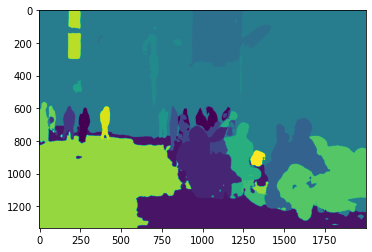

In [4]:
tmp = segments.cpu().numpy()
plt.imshow(tmp)

# If we use cv2.connectedComponets (Doesn't work)
Don't run this section

In [ ]:
tmp = segments.cpu().numpy()
tmp[tmp!=0] = 1
plt.imshow(tmp)

In [26]:
np.unique(segments.cpu().numpy())

array([0, 1, 2, 3, 4], dtype=int32)

(706, 1200)
4 (706, 1200)


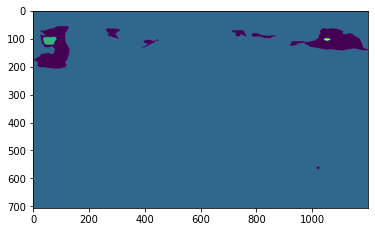

In [37]:
# ref: https://qiita.com/spc_ehara/items/72e878fc131b151c01fa#%E3%83%A9%E3%83%99%E3%83%AA%E3%83%B3%E3%82%B0%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%AE%E9%81%95%E3%81%84sauf-or-bbdt

# getting mask with connectComponents
img = segments.cpu().numpy().astype(np.uint8)
#img = segments.cpu().numpy()
print(img.shape)
#n_labels, results = cv2.connectedComponents(img)
#cv2.connectedComponentsWithAlgorithm(image, connectivity, ltype, ccltype)
cc_algo = cv2.CCL_GRANA#cv2.CCL_WU
ltype = cv2.CV_32S#cv2.CV_16U
n_labels, results = cv2.connectedComponentsWithAlgorithm(img, connectivity=4, ltype=ltype, ccltype=cc_algo)
print(n_labels, results.shape)
plt.imshow(results)

In [ ]:
areas = []
labels = []
if isinstance(segments, torch.Tensor):
    #segments = segments.cpu().numpy()

for i, v in enumerate(np.unique(segments)):
    areas.append(len(segments[segments==v]))
    ###labels.append(i)
    labels.append(v)
(areas, labels)

# Try CC3D

In [5]:
import cc3d

In [6]:
labels_in = segments.cpu().numpy()
connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
labels_out = cc3d.connected_components(labels_in, connectivity=connectivity)

In [7]:
labels_out.shape

(1333, 2000)

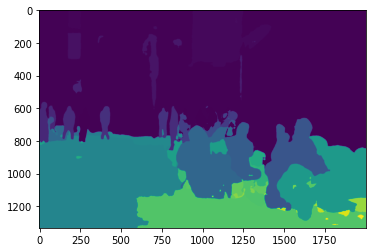

In [8]:
plt.imshow(labels_out)

In [9]:
areas = []
labels = []

for i, v in enumerate(np.unique(labels_out)):
    areas.append(len(labels_out[labels_out==v]))
    labels.append(v)
(areas, labels)

([27550,
  1287185,
  8038,
  110378,
  332,
  329,
  12274,
  18190,
  561,
  1723,
  71,
  2300,
  7,
  2755,
  80,
  16233,
  10593,
  9909,
  95,
  9193,
  7819,
  6,
  741,
  4217,
  61,
  7800,
  570,
  1,
  2,
  2,
  4,
  4084,
  3,
  884,
  6,
  57,
  95403,
  649,
  653,
  1,
  43121,
  6,
  2,
  675,
  1,
  109658,
  7235,
  1291,
  62,
  1602,
  77,
  597,
  1,
  2,
  1,
  7,
  207,
  2008,
  327,
  1,
  2,
  2,
  399543,
  2,
  15009,
  3,
  27,
  1,
  318,
  237,
  179,
  198,
  244,
  165008,
  8,
  1,
  7214,
  6590,
  607,
  4,
  151,
  3,
  31,
  6527,
  471,
  1,
  187,
  249,
  6051,
  366,
  1,
  71,
  3165,
  1,
  28,
  156,
  19,
  138,
  12001,
  208079,
  1331,
  1196,
  37,
  3876,
  5549,
  9,
  37,
  37,
  363,
  702,
  171,
  86,
  1033,
  177,
  113,
  6224,
  1,
  3,
  308,
  2,
  2,
  1,
  1,
  881,
  461,
  1,
  137,
  20,
  38,
  1614,
  1,
  78,
  32,
  5,
  662,
  145,
  133],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
 

## Depth

In [10]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/gota/.cache/torch/hub/intel-isl_MiDaS_master


In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/gota/.cache/torch/hub/intel-isl_MiDaS_master


/home/gota/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


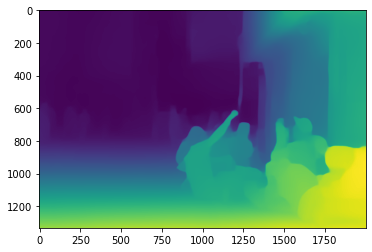

In [12]:
#filename = 'seg_inputs/sample2.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth = prediction.cpu().numpy()
plt.imshow(depth)

(1333, 2000)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]] [[ 1.3936846  1.3941566  1.3955208 ... 21.172981  21.110989  21.094757 ]
 [ 1.3940822  1.3944944  1.395648  ... 21.18565   21.127365  21.11212  ]
 [ 1.3945084  1.394752   1.3953241 ... 21.233963  21.189608  21.178066 ]
 [ 1.3939956  1.3940706  1.3940755 ... 21.299582  21.273905  21.26734  ]
 [ 1.3957975  1.3955958  1.3946254 ... 21.358973  21.350677  21.348736 ]]
(1333, 2000)
(2000, 1333)
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
11 (3144, 2) [0. 0.]
PLACE_MASK:
(845, 1754) [255]
(845, 1754) [  0 255]


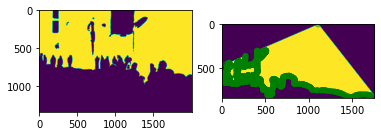

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
2 (824, 2) [186. 742.]
PLACE_MASK:
(344, 808) [255]
(344, 808) [  0 255]


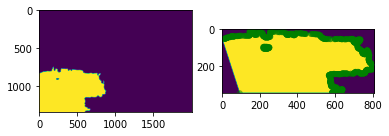

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
5 (1003, 2) [ 901. 1037.]
PLACE_MASK:
(238, 1372) [255]
(238, 1372) [  0 255]


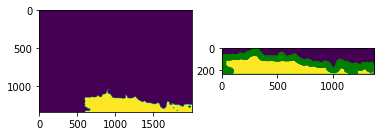

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
4 (993, 2) [1693.  768.]
PLACE_MASK:
(448, 454) [255]
(448, 454) [  0 255]


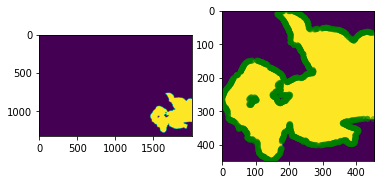

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
3 (528, 2) [941.   0.]
PLACE_MASK:
(347, 503) [255]
(347, 503) [  0 255]


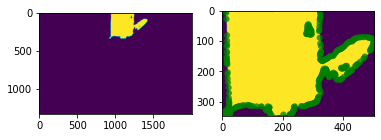

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
4 (887, 2) [963. 705.]
PLACE_MASK:
(416, 334) [255]
(416, 334) [  0 255]


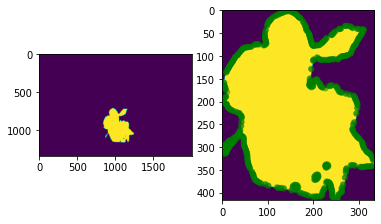

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
2 (1012, 2) [1614.  660.]
PLACE_MASK:
(360, 314) [255]
(360, 314) [  0 255]


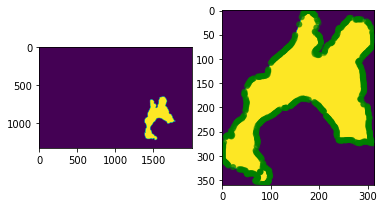

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
2 (442, 2) [1243.  686.]
PLACE_MASK:
(343, 165) [255]
(343, 165) [  0 255]


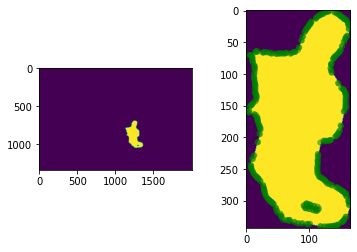

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (299, 2) [ 30. 561.]
PLACE_MASK:
(249, 9) [255]
(249, 9) [  0 255]
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (317, 2) [425. 744.]
PLACE_MASK:
(79, 651) [255]
(79, 651) [  0 255]


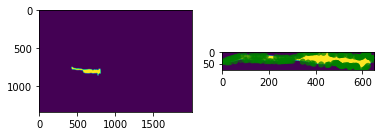

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (67, 2) [180. 140.]
PLACE_MASK:
(188, 60) [255]
(188, 60) [  0 255]


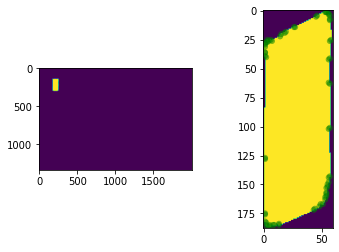

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
2 (330, 2) [1239. 1033.]
PLACE_MASK:
(173, 91) [255]
(173, 91) [  0 255]


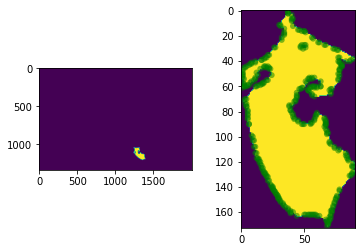

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (238, 2) [183. 587.]
PLACE_MASK:
(238, 65) [255]
(238, 65) [  0 255]


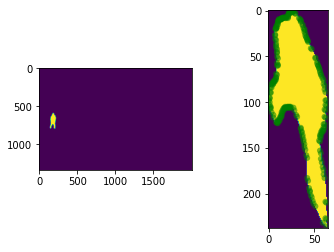

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (217, 2) [410. 588.]
PLACE_MASK:
(19, 204) [255]
(19, 204) [  0 255]
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (72, 2) [183.   0.]
PLACE_MASK:
(227, 67) [255]
(227, 67) [  0 255]


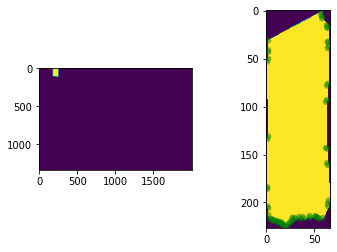

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
2 (129, 2) [760. 598.]
PLACE_MASK:
(158, 100) [255]
(158, 100) [  0 255]


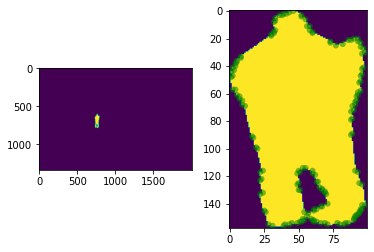

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
2 (231, 2) [880. 624.]
PLACE_MASK:
(54, 179) [255]
(54, 179) [  0 255]


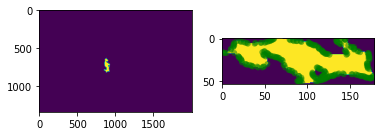

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (231, 2) [113. 706.]
PLACE_MASK:
(49, 666) [255]
(49, 666) [  0 255]


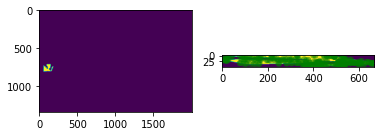

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (167, 2) [1122.  789.]
PLACE_MASK:
(84, 94) [255]
(84, 94) [  0 255]


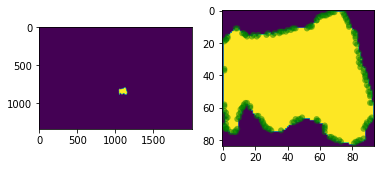

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (197, 2) [869. 796.]
PLACE_MASK:
(31, 109) [255]
(31, 109) [  0 255]
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (175, 2) [1336.  856.]
PLACE_MASK:
(79, 87) [255]
(79, 87) [  0 255]


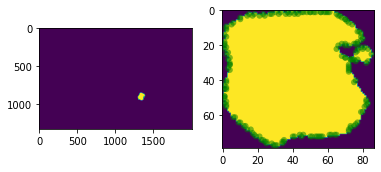

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (136, 2) [1963. 1147.]
PLACE_MASK:
(89, 110) [255]
(89, 110) [  0 255]


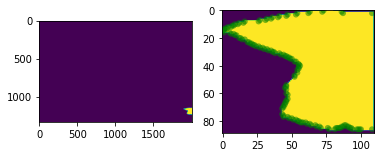

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (227, 2) [1365.  944.]
PLACE_MASK:
(107, 86) [255]
(107, 86) [  0 255]


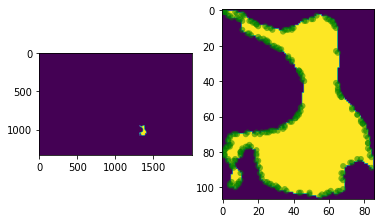

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (158, 2) [1240. 1049.]
PLACE_MASK:
(94, 68) [255]
(94, 68) [  0 255]


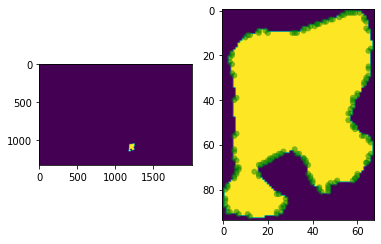

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (132, 2) [1327. 1047.]
PLACE_MASK:
(86, 78) [255]
(86, 78) [  0 255]


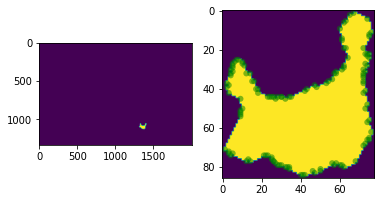

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (100, 2) [854. 967.]
PLACE_MASK:
(62, 66) [255]
(62, 66) [  0 255]


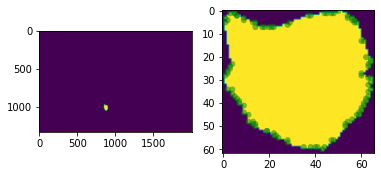

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (111, 2) [252. 425.]
PLACE_MASK:
(73, 65) [255]
(73, 65) [  0 255]


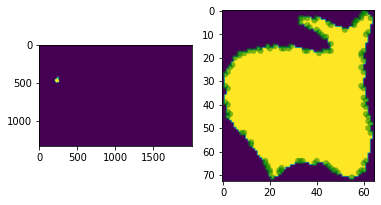

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (83, 2) [297. 728.]
PLACE_MASK:
(18, 92) [255]
(18, 92) [  0 255]
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (87, 2) [847. 177.]
PLACE_MASK:
(8, 55) [255]
(8, 55) [  0 255]
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (87, 2) [1894. 1221.]
PLACE_MASK:
(37, 70) [255]
(37, 70) [  0 255]


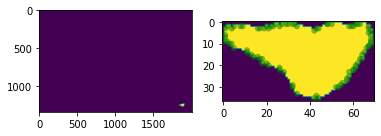

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (75, 2) [1156.  712.]
PLACE_MASK:
(49, 191) [255]
(49, 191) [  0 255]


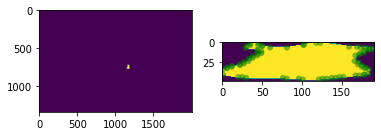

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (89, 2) [1660. 1041.]
PLACE_MASK:
(44, 44) [255]
(44, 44) [  0 255]


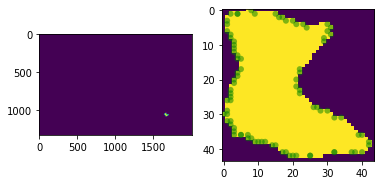

(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (69, 2) [237. 710.]
PLACE_MASK:
(18, 65) [255]
(18, 65) [  0 255]
(1333, 2000)
GET_TEXT_PLACEMENT_MASK
1 (96, 2) [1252. 1107.]
PLACE_MASK:
(32, 69) [255]
(32, 69) [  0 255]
27
Found 6 text regions.
reg_idx [0 5 2 4 8 3]
Choose the region index1
self.max_shrink_trials 5
Type your textSapplex
DEBUG text_mask 00 (344, 808)
DEBUG collision_mask 00 (344, 808)


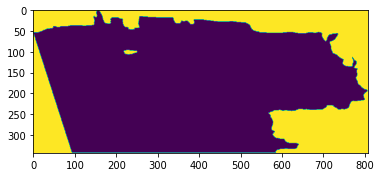

DEBUG text_mask 1 (1333, 2000)
(array([1056, 1056, 1056, ..., 1245, 1245, 1245]), array([362, 363, 364, ..., 270, 271, 272]))


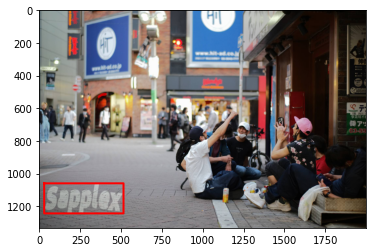

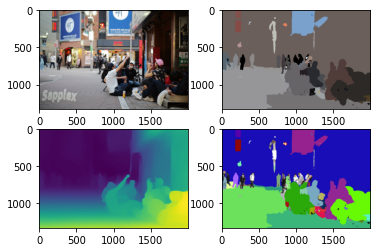

--------------------------------------------------
1


In [13]:
import numpy as np
import h5py
import os, sys, traceback
import os.path as osp
from synthgen import *
from common import *

#seg = mask
##seg = segments
seg = labels_out
print(seg.shape)

#depth = output
img = Image.open(filename)
print(seg[:5], depth[:5])
#raise
area = np.array(areas)
label = np.array(labels)
INSTANCE_PER_IMAGE = 5

# re-size uniformly:
#depth = depth[:704, :1198]
depth = depth[:seg.shape[0], :seg.shape[1]]
print(depth.shape)
sz = depth.shape[:2][::-1]
print(sz) # (1200, 706)
img = np.array(img.resize(sz, Image.ANTIALIAS))
##seg = np.array(Image.fromarray(seg).resize(sz, Image.NEAREST))
segr = cv2.resize(seg, sz, interpolation=cv2.INTER_NEAREST)
#print(segr.shape)
#raise
from synthgen import *
from common import *
DATA_PATH = 'data'
SECS_PER_IMG = 1
viz = False

RV3 = RendererV3(DATA_PATH,max_time=SECS_PER_IMG)
#print(colorize(Color.RED,'%d of %d'%(i,end_idx-1), bold=True))
res = RV3.render_text_interactive(img,depth,seg, area,label,
                    #ninstance=INSTANCE_PER_IMAGE,viz=viz)
                    ninstance=1, viz=True)
print('-'*50)
print(len(res))
#plt.imshow(res)

In [14]:
#res[0]['wordBB']
#res[0]['charBB']
print(res[0]['wordBB'].shape, res[0]['charBB'].shape)

(2, 4, 1) (2, 4, 7)


dict_keys(['img', 'charBB', 'wordBB', 'txt']) (1333, 2000, 3)
['Sapplex']


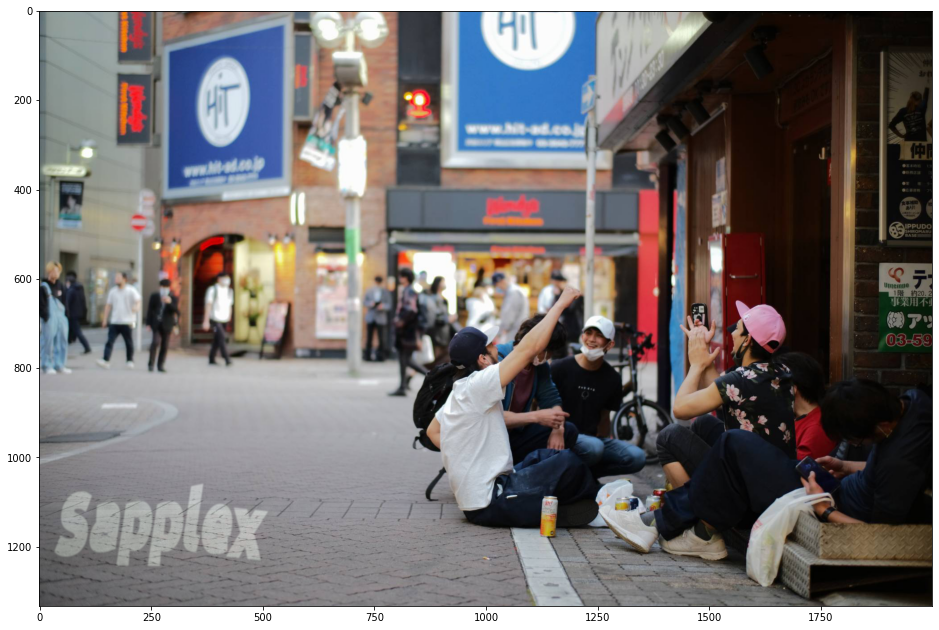

In [15]:
print(res[0].keys(), res[0]['img'].shape)
fig = plt.figure(figsize=(16,16))
plt.imshow(res[0]['img'])
print(res[0]['txt'])